In [1]:
import re
import numpy as np
import pandas as pd
import os
from hillclimbers import climb_hill
from functools import partial
from sklearn.metrics import root_mean_squared_error
from dataclasses import dataclass
from typing import *
import pandas as pd
import xgboost as xgb

In [2]:
%%time

sample_sub = pd.read_csv('/Users/yuwei-1/Documents/projects/Kaggle-tools/data/used_car_prices/sample_submission.csv', index_col='id')
train = pd.read_csv('/Users/yuwei-1/Documents/projects/Kaggle-tools/data/used_car_prices/train.csv', index_col='id')
test = pd.read_csv('/Users/yuwei-1/Documents/projects/Kaggle-tools/data/used_car_prices/test.csv', index_col='id')
Original = pd.read_csv('/Users/yuwei-1/Documents/projects/Kaggle-tools/data/used_car_prices/original_dataset.csv')

Original[['milage', 'price']] = Original[['milage', 'price']].map(
    lambda x: int(''.join(re.findall(r'\d+', x))))

train = pd.concat([train, Original], ignore_index=True)

CPU times: user 347 ms, sys: 66.5 ms, total: 413 ms
Wall time: 421 ms


In [3]:
combined = pd.concat([train, test], keys=['train', 'test'])
combined

brand                   model  model_year  milage  \
train 0                MINI           Cooper S Base        2007  213000   
      1             Lincoln                   LS V8        2002  143250   
      2           Chevrolet       Silverado 2500 LT        2002  136731   
      3             Genesis        G90 5.0 Ultimate        2017   19500   
      4       Mercedes-Benz             Metris Base        2021    7388   
...                     ...                     ...         ...     ...   
test  314218  Mercedes-Benz  GL-Class GL 450 4MATIC        2014   83315   
      314219           Audi          Q7 55 Prestige        2019   29336   
      314220           Audi    A6 3.0T Premium Plus        2012   77634   
      314221           Audi         Q7 3.0T Premium        2012  112000   
      314222      Chevrolet                Tahoe LT        2018   66840   

                  fuel_type  \
train 0            Gasoline   
      1            Gasoline   
      2       E85 Flex Fuel   
      3            Gasoline   
      4            Gasoline   
...                     ...   
test  314218       Gasoline   
      314219       Gasoline   
      314220       Gasoline   
      314221       Gasoline   
      314222       Gasoline   

                                                         engine  \
train 0            172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
      1            252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
      2       320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
      3            420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
      4            208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
...                                                         ...   
test  314218      362.0HP 3.0L V6 Cylinder Engine Gasoline Fuel   
      314219                                    3.0 Liter Turbo   
      314220      333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel   
      314221      333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel   
      314222       355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel   

                                transmission ext_col int_col  \
train 0                                  A/T  Yellow    Gray   
      1                                  A/T  Silver   Beige   
      2                                  A/T    Blue    Gray   
      3       Transmission w/Dual Shift Mode   Black   Black   
      4                          7-Speed A/T   Black   Beige   
...                                      ...     ...     ...   
test  314218                     7-Speed A/T   Black   Black   
      314219                       Automatic   White   Black   
      314220                             A/T   Black   Black   
      314221                             A/T   Black   Black   
      314222                             A/T  Silver   Black   

                                            accident clean_title    price  
train 0                                None reported         Yes   4200.0  
      1       At least 1 accident or damage reported         Yes   4999.0  
      2                                None reported         Yes  13900.0  
      3                                None reported         Yes  45000.0  
      4                                None reported         Yes  97500.0  
...                                              ...         ...      ...  
test  314218                           None reported         Yes      NaN  
      314219                           None reported         NaN      NaN  
      314220                           None reported         Yes      NaN  
      314221                           None reported         Yes      NaN  
      314222                           None reported         Yes      NaN  

[318232 rows x 12 columns]

In [4]:
from ktools.fitting.cross_validation_executor import CrossValidationExecutor
from ktools.modelling.models.catboost_model import CatBoostModel
from ktools.modelling.models.lgbm_model import LGBMModel
from ktools.modelling.models.xgb_model import XGBoostModel

In [5]:
SERIES_PATTERN = re.compile(r'^[A-Za-z0-9\-]+')
VERSION_PATTERN = re.compile(r'([0-9]+\.[0-9]+[A-Za-z]*)|([A-Z]+[0-9]*)')
TRIM_PATTERN = re.compile(r'\b(Base|Sport|Premium|Ultimate|XLT|LZ|LT|Plus|Touring|SE|LE|Limited|Platinum|Performance|S|V6|GT|EX|SX|XLE|SR|SL|SV|XSE|TRD|RS|GranSport|Signature|Quad Cab|DRW|Cabriolet|Carbon Edition|Trail Boss|Prestige|Essence|Reserve|xDrive|4MATIC|PreRunner|EcoBoost|Scat Pack|Competition|Adventure Package|Laramie|Grand Touring|Long Range)\b')

def extract_car_features(df):

    
    def extract_features(model):
        series = SERIES_PATTERN.search(model)
        trim = TRIM_PATTERN.search(model)
        
        return {
            'Series': series.group(0) if series else "missing",
            'Trim': trim.group(0) if trim else "missing"
        }
    
    extracted_features = df['model'].apply(extract_features).apply(pd.Series)
    df = pd.concat([df, extracted_features], axis=1)
    return df


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


def find_pattern(pattern, text):
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    else:
        return None

def transform(old_df):
    numeric_fill = -1
    category_fill = "missing"
    threshold = 200
    df = old_df.copy()
    
    print("#"*100)
    print("Backpacker extraction")
    print("#"*100)
    df = extract_car_features(df)
    cat_cols = [col_name for col_name in df.columns if df[col_name].dtype == 'object']

    print("#"*100)
    print("Remove rare cats")
    print("#"*100)
    # Convert categories to lower and remove rare categories
    for col_name in cat_cols:
        df[col_name] = df[col_name].str.lower()
        vc = df[col_name].value_counts()
        rare_cats = vc.loc[vc<threshold].index.values
        df.loc[df[col_name].isin(rare_cats), col_name] = category_fill
    
    print("#"*100)
    print("Engine feature extraction")
    print("#"*100)
    pattern = r'(\d*\.?\d+)\s*hp'
    df['horsepower'] = df['engine'].apply(lambda x : find_pattern(pattern, x)).astype('float64')
    pattern = r'(\d*\.?\d+)\s*(l|liter)'
    df['liters'] = df['engine'].apply(lambda x : find_pattern(pattern, x)).astype('float64')
    pattern = r'(\d*\.?\d+)\s*cylinder'
    df['cylinders'] = df['engine'].apply(lambda x : find_pattern(pattern, x)).astype('float64')
    
    bigrams = [('brand', 'clean_title'), ('brand', 'accident'), ('brand', 'fuel_type'), ('transmission', 'accident')]
    
    print("#"*100)
    print("Create bigrams")
    print("#"*100)
    for (feature_1, feature_2) in bigrams:
        new_feature_name = feature_1 + "_" + feature_2
        df[new_feature_name] = df[feature_1].astype('str') + "_" + df[feature_2].astype('str')
        cat_cols += [new_feature_name]
    
    expensive_int_color = ['dark auburn',
                            'hotspur',
                            'cobalt blue',
                            'beluga hide',
                            'linen',
                            'beluga',
                            'black / brown',
                            'nero ade',
                            'sahara tan',
                            'portland']
    
    df['expensive_int_col'] = df['int_col'].isin(expensive_int_color).astype(int)
    

    print("#"*100)
    print("Fill null values")
    print("#"*100)
    # Fill null values
    for col_name in df.columns:
        if pd.api.types.is_numeric_dtype(df[col_name]):
            df[col_name] = df[col_name].fillna(numeric_fill)
        else:
            df[col_name] = df[col_name].fillna(category_fill)
            
    df[cat_cols] = df[cat_cols].astype('category')
    
    ############################################################################################################
    X, y = df.loc['train'].drop(columns='price'), df.loc['train', 'price']
    print("#"*100)
    print("MAE LGBM")
    print("#"*100)
    params = {
            'objective': 'MAE',
            'num_boost_round': 1000,
        }

    model = LGBMModel(**params)
    kf = KFold(5, shuffle=True, random_state=42)
    mean_cv_score, mae_oof, model_list = CrossValidationExecutor(model,
                                                    lambda y, yh : mean_squared_error(y, yh, squared=False),
                                                    kf,
                                                    ).run(X, y)
    df['MAE_feature'] = 0.0
    df.loc['train', 'MAE_feature'] = mae_oof
    
    for model in model_list:        
        df.loc['test', 'MAE_feature'] = df.loc['test', 'MAE_feature'].values + model.predict(df.loc['test'].drop(columns=['price',
                                                                                    'MAE_feature'])) / len(model_list)
        
    ############################################################################################################    
    
    print("#"*100)
    print("No outlier LGBM")
    print("#"*100)
    
    X, y = df.loc['train'].drop(columns=['price', 'MAE_feature']), df.loc['train', 'price']
    params = {
            'objective': 'rmse',
            'num_boost_round': 1000,
        }

    def remove_outliers(train_tuple, threshold=300000):
        X, y = train_tuple
        mask = (y < threshold)
        return X[mask], y[mask]

    model = LGBMModel(**params)
    kf = KFold(5, shuffle=True, random_state=42)
    mean_cv_score, oof, model_list = CrossValidationExecutor(model,
                                                    lambda y, yh : mean_squared_error(y, yh, squared=False),
                                                    kf,
                                                    ).run(X, y, local_transform_list=[remove_outliers])
    df['without_outlier_feature'] = 0.0
    df.loc['train', 'without_outlier_feature'] = oof
    
    for model in model_list:
        df.loc['test', 'without_outlier_feature'] = df.loc['test', 'without_outlier_feature'].values + model.predict(df.loc['test'].drop(columns=['price',
                                                                                                'without_outlier_feature', 'MAE_feature'])) / len(model_list)
    
    ############################################################################################################
    
    print("#"*100)
    print("Regular RMSE LGBM")
    print("#"*100)
    
    X = df.loc['train'].drop(columns=['price', 'without_outlier_feature'])
    y = df.loc['train', 'price']

    param = {
        'objective': 'MSE',
        'num_boost_round': 1000,
        'random_state' : 42
        }

    model = LGBMModel(**param)
    kf = KFold(5, shuffle=True, random_state=42)
    mean_cv_score, mse_oof, model_list = CrossValidationExecutor(model,
                                                    lambda y, yh : mean_squared_error(y, yh, squared=False),
                                                    kf,
                                                    ).run(X, y)
    df['MSE_feature'] = 0.0
    df.loc['train', 'MSE_feature'] = mse_oof 
    for model in model_list:
        df.loc['test', 'MSE_feature'] = df.loc['test', 'MSE_feature'].values + model.predict(df.loc['test'].drop(columns=['price',
                                                                                    'MSE_feature', 'without_outlier_feature'])) / len(model_list)
    
    return df

In [6]:
new_df = transform(combined)

####################################################################################################
Backpacker extraction
####################################################################################################
####################################################################################################
Remove rare cats
####################################################################################################
####################################################################################################
Engine feature extraction
####################################################################################################
####################################################################################################
Create bigrams
####################################################################################################
####################################################################################################
Fill null v

/Users/yuwei-1/anaconda3/envs/ktools_2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/yuwei-1/anaconda3/envs/ktools_2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/yuwei-1/anaconda3/envs/ktools_2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/yuwei-1/anaconda3/envs/ktools_2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is depr

####################################################################################################
OOF prediction score :  73603.90072538523
Mean 5-cv results : 73532.73766725117 +- 3236.0982318920337
####################################################################################################
####################################################################################################
No outlier LGBM
####################################################################################################


/Users/yuwei-1/anaconda3/envs/ktools_2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/yuwei-1/anaconda3/envs/ktools_2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/yuwei-1/anaconda3/envs/ktools_2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/yuwei-1/anaconda3/envs/ktools_2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is depr

####################################################################################################
OOF prediction score :  72890.73947157731
Mean 5-cv results : 72819.1917996743 +- 3229.035027316773
####################################################################################################
####################################################################################################
Regular RMSE LGBM
####################################################################################################


/Users/yuwei-1/anaconda3/envs/ktools_2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/yuwei-1/anaconda3/envs/ktools_2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/yuwei-1/anaconda3/envs/ktools_2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/yuwei-1/anaconda3/envs/ktools_2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is depr

####################################################################################################
OOF prediction score :  72940.6699018678
Mean 5-cv results : 72875.29006216994 +- 3087.8358733662653
####################################################################################################


/Users/yuwei-1/anaconda3/envs/ktools_2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/yuwei-1/anaconda3/envs/ktools_2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [7]:
# lgb_params = {"num_leaves": 426,
#                      "max_depth": 20,
#                      "learning_rate": 0.011353178352988012,
#                      "n_estimators": 884,
#                      "subsample": 0.5772552201954328,
#                      "colsample_bytree": 0.9164865430101521,
#                      "reg_alpha": 1.48699088003429e-06,
#                      "reg_lambda": 0.41539458543414265,
#                      "min_data_in_leaf": 73,
#                      "feature_fraction": 0.751673655170548,
#                      "bagging_fraction": 0.5120415391590843,
#                      "bagging_freq": 2,
#                      "min_child_weight": 0.017236362383443497,
#                      "cat_smooth": 54.81317407769262,
#                      "verbose" : -1,
#                      "boosting_type" : "gbdt",
#                      "objective" : "RMSE"}

from ktools.modelling.create_hill_climber_from_params import CreateHillClimber
from ktools.modelling.models.hgb_model import HGBModel
from ktools.modelling.models.knn_model import KNNModel
from sklearn.metrics import root_mean_squared_error


# lgb_params = {'num_leaves': 280, 'max_depth': 14, 'learning_rate': 0.012732203122744722, 'num_boost_round': 910, 'subsample': 0.5433169622728463, 'colsample_bytree': 0.8994654078363041, 'reg_alpha': 0.003365552635560128, 'reg_lambda': 4.86054247720564e-05, 'min_data_in_leaf': 93, 'feature_fraction': 0.8658760205714685, 'bagging_fraction': 0.6263137171449985, 'bagging_freq': 2, 'min_child_weight': 0.1567987880086431, 'cat_smooth': 92.44970425722772}

# lgbrf_params = {'boosting_type' : 'rf', 'num_leaves': 416, 'max_depth': 10, 'learning_rate': 0.29878113696134817, 'num_boost_round': 155, 'subsample': 0.5146981782669086, 'colsample_bytree': 0.6802672845290882, 'reg_alpha': 3.72418987215723e-05, 'reg_lambda': 0.09742367812466012, 'min_data_in_leaf': 90, 'feature_fraction': 0.682402778458027, 'bagging_fraction': 0.6199615701114239, 'bagging_freq': 3, 'min_child_weight': 0.00019854426515378276, 'cat_smooth': 72.66846341329637}

# lgbxt_params = {'extra_trees' : True, 'num_leaves': 267, 'max_depth': 27, 'learning_rate': 0.013329061769098881, 'num_boost_round': 622, 'subsample': 0.9272129180560263, 'colsample_bytree': 0.9337728578994179, 'reg_alpha': 0.005936172293991621, 'reg_lambda': 2.8308017468852374e-05, 'min_data_in_leaf': 41, 'feature_fraction': 0.6176283288541762, 'bagging_fraction': 0.6619019559714052, 'bagging_freq': 2, 'min_child_weight': 0.007116895677043118, 'cat_smooth': 1.641684346318527}

# cat_params = {'max_bin': 343, 'learning_rate': 0.07372402300575284, 'depth': 15, 'iterations': 898, 'bagging_temperature': 31.554515680968088, 'subsample': 0.9229527513355164, 'colsample_bylevel': 0.7888921044832126, 'min_data_in_leaf': 885.7011118582786, 'l2_leaf_reg': 9.941096483417914, 'grow_policy': 'Lossguide', 'leaf_estimation_iterations': 5, 'random_strength': 5.477274239698739, 'leaf_estimation_method': 'Gradient'}

# xgb_params = {'max_bin': 453, 'learning_rate': 0.013229210325289916, 'max_depth': 47, 'num_boost_round': 595, 'gamma': 0.33475286711968755, 'min_child_weight': 98.24750756429152, 'subsample': 0.7311246006017413, 'colsample_bytree': 0.9012989030426084, 'colsample_bylevel': 0.7231130661378029, 'colsample_bynode': 0.648159773968677, 'reg_alpha': 0.06132137087526989, 'reg_lambda': 3.0400659248344227e-06, 'max_cat_threshold': 6, 'grow_policy': 'depthwise'}

# xgblinear_params = {'booster' : "gbtree", 'max_bin': 480, 'learning_rate': 0.1138017877924544, 'max_depth': 41, 'num_boost_round': 973, 'gamma': 4.293240786960842, 'min_child_weight': 0.6644929659535678, 'subsample': 0.7278340503730034, 'colsample_bytree': 0.8692112914095523, 'colsample_bylevel': 0.9854135964777248, 'colsample_bynode': 0.9909843523663984, 'reg_alpha': 0.07408634592366764, 'reg_lambda': 0.007120526354190246, 'max_cat_threshold': 658, 'grow_policy': 'lossguide'}

# knn_params = {'smooth': 1760.0224185369043, 'weights': 'distance', 'n_neighbors': 989, 'min_max_scaling': False}

# lgb_model = LGBMModel(stopping_rounds=20,
#                         **lgb_params)
# lgbrf_model = LGBMModel(stopping_rounds=20,
#                         **lgbrf_params)
# lgbxt_model = LGBMModel(stopping_rounds=20,
#                         **lgbxt_params)
# cat_model = CatBoostModel(stopping_rounds=20,
#                         **cat_params)
# xgb_model = XGBoostModel(stopping_rounds=10,
#                         **xgb_params)
# xgblinear_model = XGBoostModel(stopping_rounds=10,
#                         **xgblinear_params)
# knn_model = KNNModel([col_name for col_name in new_df.columns if new_df[col_name].dtype == 'category'],
#                 **knn_params
#                 )

lgb_params = {'early_stopping_rounds': 71, 'num_leaves': 427, 'max_depth': 6, 'learning_rate': 0.011102396619119378, 'num_boost_round': 580, 'subsample': 0.911100876838778, 'colsample_bytree': 0.7010108753681068, 'reg_alpha': 2.811645436859309e-06, 'reg_lambda': 2.286027333037273e-05, 'min_data_in_leaf': 78, 'feature_fraction': 0.7159446581182234, 'bagging_fraction': 0.5211025183767474, 'bagging_freq': 1, 'min_child_weight': 0.0020610251574775243, 'cat_smooth': 99.99511889193307}
lgb_model = LGBMModel(**lgb_params)

cat_params = {'early_stopping_rounds': 23, 'max_bin': 247, 'learning_rate': 0.0850191083887714, 'depth': 8, 'iterations': 963, 'bagging_temperature': 72.31045224497224, 'subsample': 0.7572201482549041, 'colsample_bylevel': 0.9834646446717988, 'min_data_in_leaf': 168.72764807669975, 'l2_leaf_reg': 5.336908669437448, 'grow_policy': 'SymmetricTree', 'leaf_estimation_iterations': 3, 'random_strength': 3.3383149768988236, 'leaf_estimation_method': 'Newton'}
cat_model = CatBoostModel(**cat_params)

xgb_params = {'early_stopping_rounds': 8, 'max_bin': 149, 'learning_rate': 0.013953743782599707, 'max_depth': 35, 'num_boost_round': 873, 'gamma': 2.6952508860883504, 'min_child_weight': 87.81545615100626, 'subsample': 0.810622785046154, 'colsample_bytree': 0.5376291735243263, 'colsample_bylevel': 0.6492000220599348, 'colsample_bynode': 0.5612689485326161, 'reg_alpha': 0.2277234511369887, 'reg_lambda': 1.6010913241456725e-05, 'max_cat_threshold': 10, 'grow_policy': 'lossguide'}
#{'early_stopping_rounds': 41, 'max_bin': 402, 'learning_rate': 0.02609752135980675, 'max_depth': 11, 'num_boost_round': 763, 'gamma': 8.06834739267264, 'min_child_weight': 93.65164840715298, 'subsample': 0.7063088384557132, 'colsample_bytree': 0.6860090428963916, 'colsample_bylevel': 0.8882064803709984, 'colsample_bynode': 0.6704017701265089, 'reg_alpha': 3.275678567945111, 'reg_lambda': 1.0206791961172381, 'max_cat_threshold': 13, 'grow_policy': 'depthwise'}
xgb_model = XGBoostModel(**xgb_params)

xgblinear_params = {'booster' : 'gblinear', 'early_stopping_rounds': 44, 'max_bin': 42, 'learning_rate': 0.29989740620655875, 'max_depth': 30, 'num_boost_round': 999, 'gamma': 0.846346393753229, 'min_child_weight': 2.193261578959557, 'subsample': 0.7106017628092185, 'colsample_bytree': 0.9183263649918635, 'colsample_bylevel': 0.638109723519647, 'colsample_bynode': 0.8565483038886685, 'reg_alpha': 0.0025476453126042366, 'reg_lambda': 0.0186139740581913, 'max_cat_threshold': 17, 'grow_policy': 'lossguide'}
xgblinear_model = XGBoostModel(**xgblinear_params)

knn_params = {'smooth': 9882.90118748393, 'weights': 'distance', 'n_neighbors': 799, 'min_max_scaling': False}#{'smooth': 8546.481717439361, 'weights': 'distance', 'n_neighbors': 787, 'min_max_scaling': False}
knn_model = KNNModel([col_name for col_name in new_df.columns if new_df[col_name].dtype == 'category'],
                **knn_params
                )

hgb_params = {'max_bins': 254, 'learning_rate': 0.020481174471855185, 'max_depth': 11, 'max_leaf_nodes': 12, 'min_samples_leaf': 328, 'num_boost_round': 381, 'validation_fraction': 0.07730978759573132, 'early_stopping_rounds': 142, 'l2_regularization': 1.7032925441573725e-05, 'max_features': 0.5758526025396319, 'interaction_cst': 'pairwise', 'tol': 0.0002260304766721017, 'smooth': 176.52971404633328}
hgb_model = HGBModel(**hgb_params)

model_list = [xgblinear_model, lgb_model, cat_model, knn_model, hgb_model]
model_names = ['xgblinear', 'lgb', 'cat', 'knn', 'hgb']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

model_features = {'xgblinear' : None,
                  'lgb' : ['brand', 'model_year', 'milage', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'clean_title', 'Trim', 'horsepower', 'liters', 'cylinders', 'brand_clean_title', 'brand_fuel_type', 'transmission_accident', 'expensive_int_col', 'MAE_feature', 'without_outlier_feature'],
                  'cat' : None,
                  'xgb' : ['model_year', 'milage', 'fuel_type', 'int_col', 'accident', 'clean_title', 'Trim', 'horsepower', 'liters', 'cylinders', 'brand_clean_title', 'brand_accident', 'brand_fuel_type', 'expensive_int_col', 'MAE_feature', 'without_outlier_feature', 'MSE_feature'],
                  'knn' : None,
                  'hgb' : ['model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'clean_title', 'Series', 'Trim', 'liters', 'cylinders', 'brand_accident', 'brand_fuel_type', 'transmission_accident', 'expensive_int_col', 'MAE_feature', 'without_outlier_feature']}

hcobj = CreateHillClimber(new_df.loc['train'],
                  new_df.loc['test'],
                  model_list,
                  model_names,
                  model_features,
                  root_mean_squared_error,
                  target_col_name='price',
                  kfold=kf
                  )

In [8]:
hillclimber = hcobj.fit()

####################################################################################################
OOF prediction score :  72551.02829108576
Mean 5-cv results : 72481.06786891664 +- 3185.5748879061334
####################################################################################################
####################################################################################################
OOF prediction score :  72470.95245547841
Mean 5-cv results : 72400.80059164886 +- 3188.170941203483
####################################################################################################
####################################################################################################
OOF prediction score :  72504.83670221934
Mean 5-cv results : 72438.40147867962 +- 3103.3165881965833
####################################################################################################
#########################################################################################

In [9]:
additional_predictions = {
                          # "ag-small" : ("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/oof_pred_ag_small.csv",
                          #           "/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/test_pred_ag_small.csv"),
                        # "ag-large" : ("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/oof_pred_ag_large.csv",
                        #             "/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/test_pred_ag_large.csv"),
                          # "ag-mae" : ("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/oof_pred_mae.csv",
                          #             "/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/submission_mae.csv"),
                          # "ag-medae" : ("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/oof_pred_medae.csv",
                          #               "/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/submission_medae.csv"),
                          # "ag-r2" : ("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/oof_pred_r2.csv",
                          #            "/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/submission_r2.csv"),
                          # "ag-all" : ("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/oof_pred_ag_large_all.csv",
                          #             "/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/test_pred_ag_large_all.csv"),
                          "agnofe" : ("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/agnofe_train_oof.csv",
                                      "/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/agnofe_test.csv"),
                          "xgb" : ("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/train_oof_xgb.csv",
                                   "/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/test_pred_xgb.csv"),
                          # "s1" : ("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/laml_s1.csv",
                          #         "/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/test_laml_s1.csv"),
                          "s2" : ("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/laml_s2.csv",
                                  "/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/test_laml_s2.csv"),
                          # "s3" : ("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/laml_s3.csv",
                          #         "/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/test_laml_s3.csv")
                          # "laml" : ("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/oof_pred_lightautoml.csv",
                          #           "/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/test_pred_lightautoml.csv"),
                          # "laml_lgbmonly" : ("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/lightautoml_lgb_oof_pred.csv",
                          #                    "/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/test_lgb_pred_lightautoml.csv"),
                          # "laml_lgb_cb" : ("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/lightautoml_oof_pred_lgbcb.csv",
                          #                  "/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/test_pred_lightautoml_lgbcb.csv"),
                          # "laml_lgb_cb_tuned" : ("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/lightautoml_lgbcbtuned_oof_pred.csv",
                          #                        "/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/test_lgbcbtuned_pred_lightautoml.csv"),
                          # "laml_catonly" : ("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/lightautoml_cat_oof_pred.csv",
                          #                   "/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/test_cat_pred_lightautoml.csv"),
                          # "laml_nn_feats" : ("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/lightautoml_nn_oof_pred.csv",
                          #               "/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/test_nn_pred_lightautoml.csv"),
                          # "ag-serkanpolat" : ("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/serkan_polat_oof.csv",
                          #                     "/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/serkan_polat_test_pred.csv")
                        }

hillclimber.load_saved_prediction_files(additional_predictions)

In [10]:
hillclimber.train_oof_pred

,xgblinear,lgb,cat,knn,hgb,agnofe,LightGBM_BAG_L1,RandomForestMSE_BAG_L1,CatBoost_BAG_L1,ExtraTreesMSE_BAG_L1,...,NeuralNetFastAI_BAG_L2,XGBoost_BAG_L2,NeuralNetTorch_BAG_L2,LightGBMLarge_BAG_L2,CatBoost_r177_BAG_L2,NeuralNetTorch_r79_BAG_L2,LightGBM_r131_BAG_L2,WeightedEnsemble_L3,xgb,s2
0,7791.857422,9301.578329,12900.960721,10416.035920,9176.209184,12576.5205,14350.768,8246.827,8754.909,8970.236,...,6192.9766,13661.438,9686.796,17436.588,9732.906,3158.3062,35800.860,10244.473,9844.610352,9054.477
1,10493.219727,10062.900269,11873.642439,9681.199646,8963.655699,11478.5690,16503.268,9440.047,8650.180,9856.540,...,8989.2460,12856.191,5564.095,16763.398,9853.596,1645.3550,33868.460,9381.866,10649.995117,10895.320
2,11503.007812,12492.703551,13302.887472,10570.905999,11263.642779,13222.6170,16106.463,12328.178,14191.556,12059.747,...,20185.1250,14287.026,11752.143,16763.398,11740.140,2806.4570,33868.460,11893.462,11737.752930,13312.102
3,59680.839844,61579.783946,61727.945246,57429.947809,62231.307210,54428.0300,52704.902,53731.348,64416.598,58536.465,...,56412.8800,57312.594,57401.203,53958.700,58331.000,45101.0660,48078.930,56227.117,58572.082031,55743.080
4,82862.914062,87924.894214,79915.093247,78864.711878,79457.859979,90901.1600,84013.766,81546.940,72254.440,75993.380,...,92579.1100,82052.060,74325.586,81323.920,83447.016,70891.1000,56996.188,80973.260,95151.718750,75630.695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192537,230032.375000,259339.669795,222042.273819,208123.580546,227721.631359,293079.3400,303064.030,216381.100,241254.860,256055.520,...,268839.0600,252515.310,183608.520,283465.500,244650.830,239464.8100,97512.730,253593.110,228661.812500,320807.700
192538,68068.546875,70393.622853,64568.022479,67616.907444,67519.280853,72394.9200,58164.668,48125.566,78189.836,51384.457,...,85592.6900,65488.992,57626.715,57591.130,64929.887,76341.7500,49150.234,67757.530,75833.218750,64256.850
192539,98430.218750,95862.287244,90779.444986,103080.155971,95445.232947,99458.6640,73053.630,85965.630,84900.510,81837.375,...,84935.2100,85286.516,86482.080,78681.230,89711.900,68959.0800,54894.137,87966.380,91634.523438,78076.160
192540,67614.664062,62903.473370,66931.690126,63561.634696,64637.186556,46951.6900,51560.960,60950.110,64216.300,57028.473,...,55015.5620,60744.523,62366.223,57028.707,62538.360,67756.8000,49138.330,61951.640,63584.605469,62452.930


In [57]:
hillclimber.train_oof_pred = hillclimber.train_oof_pred.loc[:,~hillclimber.train_oof_pred.columns.duplicated()].copy()
hillclimber.test_pred = hillclimber.test_pred.loc[:,~hillclimber.test_pred.columns.duplicated()].copy()

# hillclimber.train_oof_pred.drop(columns=["s3"], inplace=True)
# hillclimber.test_pred.drop(columns=["s3"], inplace=True)

print(hillclimber.train_oof_pred.head(5))
print(hillclimber.test_pred.head(5))

      xgblinear           lgb           cat           knn           hgb  \
0   7791.857422   9301.578329  12900.960721  10416.035920   9176.209184   
1  10493.219727  10062.900269  11873.642439   9681.199646   8963.655699   
2  11503.007812  12492.703551  13302.887472  10570.905999  11263.642779   
3  59680.839844  61579.783946  61727.945246  57429.947809  62231.307210   
4  82862.914062  87924.894214  79915.093247  78864.711878  79457.859979   

       agnofe  LightGBM_BAG_L1  RandomForestMSE_BAG_L1  CatBoost_BAG_L1  \
0  12576.5205        14350.768                8246.827         8754.909   
1  11478.5690        16503.268                9440.047         8650.180   
2  13222.6170        16106.463               12328.178        14191.556   
3  54428.0300        52704.902               53731.348        64416.598   
4  90901.1600        84013.766               81546.940        72254.440   

   ExtraTreesMSE_BAG_L1  ...  NeuralNetFastAI_BAG_L2  XGBoost_BAG_L2  \
0              8970.236  .

In [ ]:
robhatch_oof = pd.read_parquet("/Users/yuwei-1/Downloads/train_v1.parquet")
robhatch_test = pd.read_parquet("/Users/yuwei-1/Downloads/test_v1.parquet")

pred_cols = [col_name for col_name in robhatch_oof.columns if "pred" in col_name]

In [59]:
full_oof_pred = pd.concat([hillclimber.train_oof_pred, pd.read_csv("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/OOF_LightAutoMLTestersModels.csv", index_col=0), robhatch_oof[pred_cols]], axis=1)

full_oof_pred.drop(columns='BLEND', inplace=True)
full_oof_pred.dropna(inplace=True)
full_oof_pred

,xgblinear,lgb,cat,knn,hgb,agnofe,LightGBM_BAG_L1,RandomForestMSE_BAG_L1,CatBoost_BAG_L1,ExtraTreesMSE_BAG_L1,...,preds_lgb_15fold_seed213_build503112,preds_lgb_15fold_seed213_build503113,preds_lgb_15fold_seed213_build503114,preds_lgb_15fold_seed213_build503115,preds_lgb_15fold_seed213_build503116,preds_lgb_15fold_seed213_build503117,preds_lgb_15fold_seed213_build503118,preds_lgb_15fold_seed213_build503119,preds_lgb_15fold_seed213_build503120,preds_lgb_15fold_seed213_build503121
0,7791.857422,9301.578329,12900.960721,10416.035920,9176.209184,12576.5205,14350.768,8246.827,8754.909,8970.236,...,12310.440130,8878.214768,8034.547425,11207.264314,8548.337868,9703.059029,9405.890594,9227.765501,8094.247466,6880.699536
1,10493.219727,10062.900269,11873.642439,9681.199646,8963.655699,11478.5690,16503.268,9440.047,8650.180,9856.540,...,13893.224680,10655.730682,11060.180415,10254.738600,10768.560681,11580.900510,11795.662980,10088.875466,12072.707786,10681.759483
2,11503.007812,12492.703551,13302.887472,10570.905999,11263.642779,13222.6170,16106.463,12328.178,14191.556,12059.747,...,15238.437705,13008.331530,14030.213572,15509.611819,13385.519606,14323.064154,13891.330738,12349.733516,12262.289739,13256.660691
3,59680.839844,61579.783946,61727.945246,57429.947809,62231.307210,54428.0300,52704.902,53731.348,64416.598,58536.465,...,65486.518378,67783.019737,66519.948406,66373.471186,67189.200263,68514.556291,69527.823163,68551.810600,67527.695997,65261.203808
4,82862.914062,87924.894214,79915.093247,78864.711878,79457.859979,90901.1600,84013.766,81546.940,72254.440,75993.380,...,72774.819256,79795.604937,70829.540215,75503.284862,67281.570625,73541.202392,67130.774356,80700.102486,79757.445893,71030.104588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,46757.296875,45472.595265,43876.531974,48394.077042,46816.500507,48400.0040,42904.790,45640.156,43461.594,40419.156,...,44277.659699,43170.525408,44815.123198,44221.523913,44634.235832,44781.102587,45408.084478,42425.409988,42757.643831,44226.180980
188529,59699.929688,54616.554502,54209.164448,52855.261001,54516.834774,44305.3320,51665.516,72912.016,55784.855,68083.820,...,55361.095659,59221.904013,55556.319769,56734.202106,55978.915510,56731.790400,56790.495078,59010.136223,60338.920773,54455.666365
188530,91931.546875,88397.984990,92237.903129,97326.095093,90200.383474,83239.5200,77665.350,94300.375,90458.875,92234.805,...,84156.470727,83664.557301,87230.567946,87000.730488,90142.299990,88618.761432,88525.025057,81979.154946,83113.339132,88213.523342
188531,65556.492188,67061.949852,65331.380401,70021.379893,61044.890491,71920.6500,57908.130,58070.027,59481.406,52305.050,...,61395.426617,57351.928715,64291.931377,61080.083147,63438.546689,59410.327999,65548.638952,59404.520220,60857.176779,63370.815904


In [62]:
robhatch = robhatch_test[pred_cols]
robhatch.index = hillclimber.test_pred.index

full_test_pred = pd.concat([hillclimber.test_pred, pd.read_csv("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/PRED_LightAutoMLTestersModels.csv", index_col=0), robhatch], axis=1)

full_test_pred.drop(columns='BLEND', inplace=True)
full_test_pred
# full_oof_pred.dropna(inplace=True)

,xgblinear,lgb,cat,knn,hgb,agnofe,LightGBM_BAG_L1,RandomForestMSE_BAG_L1,CatBoost_BAG_L1,ExtraTreesMSE_BAG_L1,...,preds_lgb_15fold_seed213_build503112,preds_lgb_15fold_seed213_build503113,preds_lgb_15fold_seed213_build503114,preds_lgb_15fold_seed213_build503115,preds_lgb_15fold_seed213_build503116,preds_lgb_15fold_seed213_build503117,preds_lgb_15fold_seed213_build503118,preds_lgb_15fold_seed213_build503119,preds_lgb_15fold_seed213_build503120,preds_lgb_15fold_seed213_build503121
188533,17311.228516,18779.773692,18967.814599,19771.104609,19032.174313,20977.830,21389.027,16662.470,18073.180,17086.200,...,20389.068148,18532.155465,17471.051242,18439.461626,17111.134828,18116.787303,17216.091757,17809.719032,17491.152444,18082.400665
188534,74507.042969,74195.440716,74314.391573,75728.141722,73754.588065,85033.070,76430.664,85683.300,83609.060,68899.520,...,71414.342592,75863.157411,75686.969925,72586.749776,73731.105916,74050.082105,72020.320630,77271.402152,74543.928274,75456.517390
188535,61661.458008,59382.773219,60935.759494,57026.678486,58838.155506,58235.410,53604.746,50579.310,59461.406,56655.746,...,52648.313938,54053.296338,53179.413165,54148.144717,53201.428657,53974.681003,52635.273632,54381.667043,51783.956630,52324.928345
188536,23579.476562,27096.058210,28791.942974,29145.186469,26347.035218,31982.086,29661.777,23895.049,28585.955,27457.940,...,32129.475871,29043.450943,30141.175482,29496.430210,29539.687342,31328.179393,30583.266436,28696.122737,26051.165272,29463.467699
188537,29453.227051,29866.435298,30348.902244,29578.183407,29543.909420,32555.695,34862.600,29433.367,32315.590,29878.816,...,31868.467037,30826.179100,30039.516774,31212.107284,30808.599272,31016.369274,30440.626712,30438.891603,29505.726141,30553.426340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314218,26675.092773,26493.786508,26399.991547,25567.268378,27673.563213,26333.527,25444.287,21877.459,32666.582,21146.258,...,28135.350270,27772.582086,29119.417710,27926.536295,29220.240038,27699.864750,29050.564589,27241.388390,29097.159523,29699.049900
314219,50213.050781,48027.577375,49216.172903,47445.388038,48110.006392,47521.460,64788.133,46805.920,51330.855,57442.390,...,48331.657180,48006.133702,48212.425635,48265.204774,47063.199473,48647.400521,49117.992330,48288.311635,46847.105626,46387.244272
314220,18222.807373,20110.130845,18917.172384,19693.657082,20437.950962,20298.938,21555.080,19661.994,20836.129,19558.686,...,25198.863847,22957.041192,22611.537345,25063.136751,22321.158868,24178.648898,23455.845476,21880.053764,21706.735881,22066.519240
314221,13036.375000,16457.965651,16859.260079,15315.434220,16150.665946,15995.067,16229.986,14765.533,16134.812,14895.487,...,18852.459768,16545.755001,17504.827124,17759.203572,17402.966255,16982.740252,17609.180786,16091.487579,17212.530180,18262.259112


In [63]:
testpred = climb_hill(new_df.loc['train'].loc[full_oof_pred.index],
        #    hillclimber.train_oof_pred,
           full_oof_pred,
        #    hillclimber.test_pred,
           full_test_pred,
           target = 'price',
           objective='minimize',
           eval_metric=partial(root_mean_squared_error),
           plot_hill=False,
           negative_weights=True
           )

   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (133 total): 

dl_cls_woclip_data:                                72511.68695 (best solo model)
preds_lgb_15fold_seed212_build502110:              72517.35065
WeightedEnsemble_L3:                               72518.53050
preds_lgb_15fold_seed212_build502112:              72526.68119
preds_lgb_15fold_seed212_build502116:              72528.80425
dl_cls_woclip_wodata:                              72533.19085
preds_lgb_15fold_seed212_build502119:              72555.64674
preds_lgb_15fold_seed207_build300104:              72556.88318
preds_lgb_15fold_seed212_build502101:              72561.27808
preds_lgb_15fold_seed207_build300103:              72562.11977
CatBoost_BAG_L2:                                   72564.04543
preds_lgb_15fold_seed213_build503121:              72564.86006
cb_clip_data:                                      72570.46992
CatBoost_r177_BAG_L2:                              72570.92139
preds_lgb_1

In [77]:
from sklearn.linear_model import Lasso


las = Lasso(alpha=1e5, fit_intercept=False)
las.fit(full_oof_pred, new_df.loc['train', 'price'].loc[full_oof_pred.index])

/Users/yuwei-1/anaconda3/envs/ktools_2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.417e+14, tolerance: 1.534e+11
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=100000.0, fit_intercept=False)

In [78]:
testpred = las.predict(full_test_pred)

In [79]:
sample_sub['price'] =  testpred#las.predict(full_test_pred)
sample_sub

,price
id,
188533,14702.740699
188534,78694.386858
188535,53386.220445
188536,26263.539650
188537,29625.995480
...,...
314218,26347.027376
314219,48844.279276
314220,18729.396449


In [73]:
sample_sub.to_csv("/Users/yuwei-1/Documents/projects/Kaggle-tools/submissions/used_cars/used_car_submission_v67.csv")

In [305]:
# best_test.train_oof_pred = pd.concat([best_test.train_oof_pred, pd.read_csv("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/OOF_LightAutoMLTestersModels.csv", index_col=0)['BLEND']], axis=1)
# best_test.train_oof_pred = best_test.train_oof_pred.dropna()
# best_test.train_oof_pred.drop(columns=['laml'], inplace=True)
best_test.train_oof_pred = best_test.train_oof_pred.loc[:,~best_test.train_oof_pred.columns.duplicated()].copy()
best_test.train_oof_pred

,xgblinear,lgb,cat,knn,hgb,ag-small,ag-mae,ag-medae,ag-r2,xgb,laml_catonly,laml_lgb_cb_tuned,laml_lgbmonly,laml_nn_feats,ag-serkanpolat
0,7791.857422,9301.578329,12900.960721,10416.035920,9176.209184,10342.567,10458.298,9348.849,9177.172,9844.610352,16403.156,12540.258,13245.170,17084.3000,9103.4800
1,10493.219727,10062.900269,11873.642439,9681.199646,8963.655699,11722.479,11197.558,9865.589,11193.502,10649.995117,13078.133,14338.642,15150.690,13471.2170,11324.3545
2,11503.007812,12492.703551,13302.887472,10570.905999,11263.642779,12761.601,12845.660,13280.038,13912.339,11737.752930,11352.797,11461.303,11707.585,11870.8955,13360.0660
3,59680.839844,61579.783946,61727.945246,57429.947809,62231.307210,58276.830,60250.570,63282.080,60561.457,58572.082031,63380.370,60433.984,58404.375,61170.4380,62141.0200
4,82862.914062,87924.894214,79915.093247,78864.711878,79457.859979,80555.330,77991.730,74312.980,79113.060,95151.718750,74765.914,76848.240,75356.500,73209.9700,84517.0800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192537,230032.375000,259339.669795,222042.273819,208123.580546,227721.631359,228297.640,220334.200,352655.120,225614.520,228661.812500,210993.480,228126.470,244026.550,221102.5600,224295.9400
192538,68068.546875,70393.622853,64568.022479,67616.907444,67519.280853,70987.530,70757.880,67069.880,69367.290,75833.218750,71071.336,69778.586,69254.414,70156.3400,68766.1400
192539,98430.218750,95862.287244,90779.444986,103080.155971,95445.232947,97806.040,99846.450,85284.570,97009.560,91634.523438,115406.330,112416.410,112976.970,108147.0100,97416.1400
192540,67614.664062,62903.473370,66931.690126,63561.634696,64637.186556,63428.140,63703.750,60619.625,60981.164,63584.605469,65879.640,66154.710,65352.695,66512.8400,62253.3900


In [306]:
# best_test.test_pred = pd.concat([best_test.test_pred, pd.read_csv("/Users/yuwei-1/Documents/projects/Kaggle-tools/ktools/modelling/Data/used_cars/PRED_LightAutoMLTestersModels.csv", index_col=0)['BLEND']], axis=1)
# best_test.test_pred.drop(columns=['laml'], inplace=True)
best_test.test_pred = best_test.test_pred.loc[:,~best_test.test_pred.columns.duplicated()].copy()
# best_test.test_pred.drop(columns=['laml_catonly'], inplace=True)
# best_test.test_pred = best_test.test_pred.dropna()
best_test.test_pred

,xgblinear,lgb,cat,knn,hgb,ag-small,ag-mae,ag-medae,ag-r2,xgb,laml_catonly,laml_lgb_cb_tuned,laml_lgbmonly,laml_nn_feats,ag-serkanpolat
188533,17311.228516,18779.773692,18967.814599,19771.104609,19032.174313,19343.6070,19219.730,18763.650,19442.900,17913.550049,19092.697,18278.941,18998.316,18981.760,19382.050
188534,74507.042969,74195.440716,74314.391573,75728.141722,73754.588065,77652.8200,74289.700,80107.360,74688.266,81477.774414,76175.020,77180.840,76242.100,75921.750,75614.820
188535,61661.458008,59382.773219,60935.759494,57026.678486,58838.155506,58982.0550,59302.730,56502.414,58766.220,56430.732422,57041.520,57490.766,57569.348,56954.203,58655.223
188536,23579.476562,27096.058210,28791.942974,29145.186469,26347.035218,30070.9550,30788.043,27360.117,29931.508,27002.433594,30448.707,30660.596,29996.790,29893.342,29737.607
188537,29453.227051,29866.435298,30348.902244,29578.183407,29543.909420,31455.8770,31552.445,30988.547,31781.781,29717.227539,30386.824,30643.406,30786.209,30523.236,31283.656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314218,26675.092773,26493.786508,26399.991547,25567.268378,27673.563213,27062.9650,27426.390,27823.740,27656.715,26225.318848,28120.336,28374.504,27910.977,29353.402,27471.865
314219,50213.050781,48027.577375,49216.172903,47445.388038,48110.006392,54203.1680,52154.210,48417.324,53495.055,49367.322266,49414.367,50381.523,48643.580,49904.330,54557.582
314220,18222.807373,20110.130845,18917.172384,19693.657082,20437.950962,19474.0860,19164.746,18299.508,19224.037,19731.197021,19272.940,19490.973,19316.730,20229.342,18491.738
314221,13036.375000,16457.965651,16859.260079,15315.434220,16150.665946,16117.7705,16422.330,16211.982,16250.578,16575.199219,16360.864,16322.670,17216.360,16647.824,16132.244


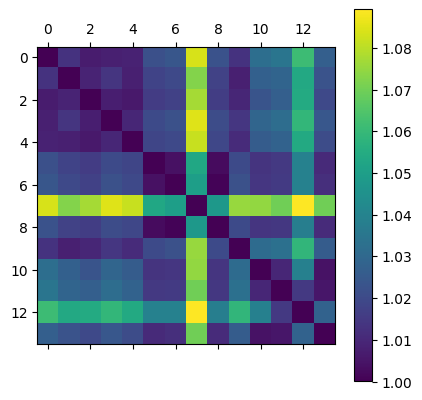

/Users/yuwei-1/anaconda3/envs/ktools_2/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:701: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


In [301]:
import matplotlib.pyplot as plt
inverse_similarity = (1/best_test.test_pred.corr()).to_numpy()

# np.fill_diagonal(inverse_similarity, 0)
from sklearn.cluster import SpectralClustering

plt.matshow(inverse_similarity)
plt.colorbar()
plt.show()

sc = SpectralClustering(n_clusters=3)
labels = sc.fit_predict(inverse_similarity)

In [256]:
# best_test.test_pred.drop(columns=['laml_lgbmonly', 'laml_lgb_cb'], inplace=True)
# best_test.train_oof_pred.drop(columns=['laml_lgbmonly', 'laml_lgb_cb'], inplace=True)


In [302]:
best_test.test_pred

,xgblinear,lgb,cat,knn,hgb,ag-small,ag-mae,ag-medae,ag-r2,xgb,laml_catonly,laml_lgb_cb_tuned,laml_lgbmonly,laml_nn_feats
188533,17311.228516,18779.773692,18967.814599,19771.104609,19032.174313,19343.6070,19219.730,18763.650,19442.900,17913.550049,19092.697,18278.941,18998.316,18981.760
188534,74507.042969,74195.440716,74314.391573,75728.141722,73754.588065,77652.8200,74289.700,80107.360,74688.266,81477.774414,76175.020,77180.840,76242.100,75921.750
188535,61661.458008,59382.773219,60935.759494,57026.678486,58838.155506,58982.0550,59302.730,56502.414,58766.220,56430.732422,57041.520,57490.766,57569.348,56954.203
188536,23579.476562,27096.058210,28791.942974,29145.186469,26347.035218,30070.9550,30788.043,27360.117,29931.508,27002.433594,30448.707,30660.596,29996.790,29893.342
188537,29453.227051,29866.435298,30348.902244,29578.183407,29543.909420,31455.8770,31552.445,30988.547,31781.781,29717.227539,30386.824,30643.406,30786.209,30523.236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314218,26675.092773,26493.786508,26399.991547,25567.268378,27673.563213,27062.9650,27426.390,27823.740,27656.715,26225.318848,28120.336,28374.504,27910.977,29353.402
314219,50213.050781,48027.577375,49216.172903,47445.388038,48110.006392,54203.1680,52154.210,48417.324,53495.055,49367.322266,49414.367,50381.523,48643.580,49904.330
314220,18222.807373,20110.130845,18917.172384,19693.657082,20437.950962,19474.0860,19164.746,18299.508,19224.037,19731.197021,19272.940,19490.973,19316.730,20229.342
314221,13036.375000,16457.965651,16859.260079,15315.434220,16150.665946,16117.7705,16422.330,16211.982,16250.578,16575.199219,16360.864,16322.670,17216.360,16647.824


In [329]:
sample_sub['price'] = best_test.test_pred['lgb']
sample_sub
sample_sub.to_csv("/Users/yuwei-1/Documents/projects/Kaggle-tools/submissions/used_cars/used_car_submission_v51.csv")

In [327]:
lgbsub = best_test.test_pred[['lgb']]
lgbsub['id'] = lgbsub.index
# lgbsub[['id', 'lgb']].rename(columns={'lgb' : 'price'}).to_csv("/Users/yuwei-1/Documents/projects/Kaggle-tools/submissions/used_cars/used_car_submission_v51.csv")

/var/folders/xs/yw83rqss71nc9hlz48gw8blh0000gn/T/ipykernel_18102/182141075.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lgbsub['id'] = lgbsub.index


In [316]:
best_test.test_pred['lgb'].to_csv("/Users/yuwei-1/Documents/projects/Kaggle-tools/submissions/used_cars/used_car_submission_v51.csv")

In [307]:
best_prediction = best_test.naive_hill_climb()

   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (15 total): 

laml_lgb_cb_tuned: 72411.94180 (best solo model)
ag-serkanpolat:    72420.05430
lgb:               72470.95246
xgb:               72476.62274
ag-r2:             72478.77829
hgb:               72494.35636
laml_nn_feats:     72498.15458
cat:               72504.83670
ag-small:          72514.40154
ag-mae:            72532.80220
laml_catonly:      72548.16018
xgblinear:         72551.02829
knn:               72610.67615
laml_lgbmonly:     72631.15652
ag-medae:          73727.01435

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: xgb | Best weight: 0.43 | Best root_mean_squared_error: 72330.85470
Iteration: 2 | Model added: ag-medae | Best weight: 0.10 | Best root_mean_squared_error: 72311.84743
Iteration: 3 | Model added: ag-serkanpolat | Best weight: 0.17 | Best root_mean_squared_error: 72307.35096
Iteration: 4 | Model added: laml_lgbmonly | Best weig

In [235]:
np.random.seed(2)
mix = np.random.permutation(best_test.test_pred.shape[1])
first = mix[:6]
second = mix[6:]

all_preds = np.array(best_test.test_pred.columns)

In [236]:
level_1_oof = []
level_1_test = []

new_test, new_oof = climb_hill(train=new_df.loc['train'],
                            oof_pred_df=best_test.train_oof_pred[list(all_preds[first])],
                            test_pred_df=best_test.test_pred[list(all_preds[first])],
                            target='price',
                            objective="minimize",
                            eval_metric=partial(root_mean_squared_error),
                            negative_weights=False,
                            plot_hill=False,
                            return_oof_preds=True)

level_1_oof += [pd.Series(new_oof, name="lvl1_1", index=best_test.train_oof_pred.index)]
level_1_test += [pd.Series(new_test, name="lvl1_1", index=best_test.test_pred.index)]

new_test, new_oof = climb_hill(train=new_df.loc['train'],
                            oof_pred_df=best_test.train_oof_pred[list(all_preds[second])],
                            test_pred_df=best_test.test_pred[list(all_preds[second])],
                            target='price',
                            objective="minimize",
                            eval_metric=partial(root_mean_squared_error),
                            negative_weights=False,
                            plot_hill=False,
                            return_oof_preds=True)

level_1_oof += [pd.Series(new_oof, name="lvl1_2", index=best_test.train_oof_pred.index)]
level_1_test += [pd.Series(new_test, name="lvl1_2", index=best_test.test_pred.index)]


# new_test, new_oof = climb_hill(train=new_df.loc['train'],
#                             oof_pred_df=best_test.train_oof_pred[list(all_preds[third])],
#                             test_pred_df=best_test.test_pred[list(all_preds[third])],
#                             target='price',
#                             objective="minimize",
#                             eval_metric=partial(root_mean_squared_error),
#                             negative_weights=False,
#                             plot_hill=False,
#                             return_oof_preds=True)

# level_1_oof += [pd.Series(new_oof, name="lvl1_3", index=best_test.train_oof_pred.index)]
# level_1_test += [pd.Series(new_test, name="lvl1_3", index=best_test.test_pred.index)]

   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (6 total): 

laml:      72359.42274 (best solo model)
lgb:       72470.95246
hgb:       72494.35636
ag-small:  72514.40154
xgblinear: 72551.02829
knn:       72610.67615

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: lgb | Best weight: 0.34 | Best root_mean_squared_error: 72318.84458
Iteration: 2 | Model added: hgb | Best weight: 0.06 | Best root_mean_squared_error: 72317.99935
   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (7 total): 

laml_lgb_cb:   72295.94734 (best solo model)
laml_lgbmonly: 72309.01888
xgb:           72476.62274
ag-r2:         72478.77829
cat:           72504.83670
ag-mae:        72532.80220
ag-medae:      73727.01435

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: xgb | Best weight: 0.27 | Best root_mean_squared_error: 72268.46945
Iteration: 2 | Model added: lam

In [237]:
level1oof = pd.concat(level_1_oof, axis=1)
level1test = pd.concat(level_1_test, axis=1)

In [238]:
new_test, new_oof = climb_hill(train=new_df.loc['train'],
                            oof_pred_df=level1oof,
                            test_pred_df=level1test,
                            target='price',
                            objective="minimize",
                            eval_metric=partial(root_mean_squared_error),
                            negative_weights=False,
                            plot_hill=False,
                            return_oof_preds=True)

   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (2 total): 

lvl1_2: 72248.92323 (best solo model)
lvl1_1: 72317.99935

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: lvl1_1 | Best weight: 0.06 | Best root_mean_squared_error: 72248.63972


In [308]:
sample_sub['price'] = best_prediction
sample_sub

,price
id,
188533,18504.426381
188534,77853.059012
188535,57452.144804
188536,28873.764430
188537,30403.558719
...,...
314218,27522.098113
314219,50201.278773
314220,19413.122463


In [309]:
sample_sub.to_csv("/Users/yuwei-1/Documents/projects/Kaggle-tools/submissions/used_cars/used_car_submission_v48.csv")

In [25]:
pd.Series(best, index=X_test.index, name="price")

In [ ]:
class BaseLGBMParamGrid():
    @staticmethod
    def get(trial : optuna.Trial, n_estimators=1000):
        if isinstance(trial, optuna.trial.FixedTrial):
            params = initparams
        else:
            params = {
                # "boosting_type" : "gbdt",
                "num_leaves" : trial.suggest_int("num_leaves", 2, 500),
                "max_depth" : trial.suggest_int("max_depth", 0, 50),
                "learning_rate" : trial.suggest_float("learning_rate", 1e-2, 1.0, log=True),
                "num_boost_round" : trial.suggest_int("num_boost_round", 50, 1000),
                "subsample" : trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "reg_alpha" : trial.suggest_float("reg_alpha", 1e-6, 10, log=True),
                "reg_lambda" : trial.suggest_float("reg_lambda", 1e-6, 10, log=True),
                "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf", 1, 100),
                "feature_fraction" : trial.suggest_float("feature_fraction", 0.5, 1.0),
                "bagging_fraction" : trial.suggest_float("bagging_fraction", 0.5, 1.0),
                "bagging_freq" : trial.suggest_int("bagging_freq", 1, 5),
                "data_sample_strategy" : "bagging",
                'min_child_weight': trial.suggest_float('min_child_weight', 1e-4, 100, log=True),
                'cat_smooth': trial.suggest_float('cat_smooth', 1, 100, log=True),
                "verbose_eval" : False,
                "log_period" : 1000,
                "random_state" : 129,
                "verbose" : -1}
        return params

In [ ]:
class BaseXGBoostParamGrid():
    @staticmethod
    def get(trial : optuna.Trial):
        params = {
            # "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
            "max_bin" : trial.suggest_int("max_bin", 2, 500),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 50),
            "num_boost_round" : trial.suggest_int("num_boost_round", 50, 1000),
            "gamma" : trial.suggest_float("gamma", 0, 10),
            "min_child_weight" : trial.suggest_float("min_child_weight", 0.1, 100, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
            "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-6, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-6, 10.0, log=True),
            "max_cat_threshold" : trial.suggest_int("max_cat_threshold", 1, 1000, log=True),
            "sampling_method" : "uniform",
            "grow_policy" : trial.suggest_categorical("grow_policy", ["lossguide", "depthwise"]),
            "random_state": 129,
            "verbosity": 0
        }
        return params

In [ ]:
class BaseCatBoostParamGrid():
    @staticmethod
    def get(trial : optuna.Trial):
        params = {
            # "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
            "max_bin" : trial.suggest_int("max_bin", 2, 500),
            "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.3, log=True),
            "depth": trial.suggest_int("depth", 3, 16),
            "iterations" : trial.suggest_int("iterations", 50, 1000),
            "bagging_temperature" : trial.suggest_float("bagging_temperature", 1, 100, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.5, 1.0),
            "min_data_in_leaf" : trial.suggest_float("min_data_in_leaf", 1, 1000, log=True),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-6, 10.0, log=True),
            "grow_policy" : trial.suggest_categorical("grow_policy", ["Lossguide", "Depthwise", "SymmetricTree"]),
            "leaf_estimation_iterations" : trial.suggest_int("leaf_estimation_iterations", 1, 5),
            "random_strength" : trial.suggest_float("random_strength", 1, 10),
            "leaf_estimation_method" : trial.suggest_categorical("leaf_estimation_method", ["Newton", "Gradient"]),
            "loss_function" : "RMSE",
            "use_best_model" : True,
            "random_seed": 129,
            "verbose": False
        }
        return params

In [29]:
train_df = new_df.loc['train']

In [31]:
xgb_params = {'early_stopping_rounds': 8, 'max_bin': 149, 'learning_rate': 0.013953743782599707, 'max_depth': 35, 'num_boost_round': 873, 'gamma': 2.6952508860883504, 'min_child_weight': 87.81545615100626, 'subsample': 0.810622785046154, 'colsample_bytree': 0.5376291735243263, 'colsample_bylevel': 0.6492000220599348, 'colsample_bynode': 0.5612689485326161, 'reg_alpha': 0.2277234511369887, 'reg_lambda': 1.6010913241456725e-05, 'max_cat_threshold': 10, 'grow_policy': 'lossguide'}
model = XGBoostModel(**xgb_params)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cve = CrossValidationExecutor(xgb_model,
                              root_mean_squared_error,
                              kf,
                              use_test_as_valid=True,
                              verbose=1
                              )
_ = cve.run(train_df[['model_year', 'milage', 'fuel_type', 'int_col', 'accident', 'clean_title', 'Trim', 'horsepower', 'liters', 'cylinders', 'brand_clean_title', 'brand_accident', 'brand_fuel_type', 'expensive_int_col', 'MAE_feature', 'without_outlier_feature', 'MSE_feature']], train_df['price'])

####################################################################################################
OOF prediction score :  72494.75623134684
Mean 5-cv results : 72424.37381876513 +- 3193.920049509081
####################################################################################################


((72494.75623134684, 72424.37381876513),
 array([ 8682.37304688, 10177.59863281, 12761.01757812, ...,
        92261.9296875 , 64097.63671875, 39175.29296875]),
  <ktools.modelling.models.xgb_model.XGBoostModel at 0x31e34fca0>])